In [487]:
import pandas as pd
import requests
import json
import datetime
from statsmodels.tsa.stattools import coint
import numpy as np
from bs4 import BeautifulSoup
import requests
import numpy as np
from scipy import stats
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Back-Testing System

Here, we will build a backtesting system for pair trading strategies. First, we will define necessary functions to fetch the historical price from Binance.


## Data Feeding 

In [488]:
#fetch Candlesticks

def getcandle(ticker,interval,startTime,endTime):
    parameters = {'symbol': str(ticker),'interval': str(interval),'startTime': int(startTime),'endTime': int(endTime)}
    res = json.loads(requests.get("https://api.binance.com/api/v3/klines", params=parameters).text)
    GetPrice = pd.DataFrame(res)
    GetPrice.columns = ['Open time', 'Open', 'High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']
    GetPrice['Open time'] = GetPrice['Open time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    GetPrice['Close time'] = GetPrice['Close time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    GetPrice["Open time"] = pd.to_datetime(GetPrice["Open time"])
    GetPrice["Close time"] = pd.to_datetime(GetPrice["Open time"])
    GetPrice["Open"] = GetPrice["Open"] .astype('float')
    GetPrice["High"] = GetPrice["High"] .astype('float')
    GetPrice["Low"] = GetPrice["Low"] .astype('float')
    GetPrice["Close"] = GetPrice["Close"] .astype('float')
    GetPrice["Volume"] = GetPrice["Volume"] .astype('float')
    return(GetPrice)

#Generate DataFrame
def priceFrame(ticker,interval,startTime,endTime):
    Frame = pd.DataFrame()
    for i in ticker:
        close = (getcandle(i,interval,startTime,endTime).set_index('Open time')['Close']).astype(float)
        Frame = pd.concat([Frame,close],axis=1)
    Frame.columns = ticker
    Frame.index = pd.DatetimeIndex(Frame.index)
    return(Frame)

#Ciontegation Check


## Pair Selection Methodology

In [489]:
#Min-Max Normalize
def MinMax_Normalize(df):
    return((df - df.min())/(df.max() - df.min()))

#Standardize
def Standard_Normalize(df):
    return((df - df.mean())/df.std())

def Relative_Return(df):
    return(((df - df.shift())/df.shift()).dropna())

#Ciontegation Check
def cointplot(Combine):
    ncol = len(Combine.columns)
    cointMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            st, pvalue, crit = coint(Combine[Combine.columns[i]],Combine[Combine.columns[j]])
            cointMat[i,j] = pvalue
    cointTab = pd.DataFrame(cointMat)
    cointTab.columns = Combine.columns
    cointTab.index = Combine.columns
    return(cointTab)

#Get Top Marekt Cap Coin from https://www.coingecko.com/en
def GetTopCoin(Num):
    URL = requests.get('https://www.coingecko.com/en')
    soup = BeautifulSoup(URL.text, 'html.parser')
    TickerList = soup.find_all("span", {"class": "tw-hidden d-lg-inline font-normal text-3xs ml-2"})
    TickerRank = [i.text.replace("\n", "") for i in TickerList]
    return(TickerRank[0:(int(Num)-1)])


def Pair_Selection_Smallest_Distance(df):
    row, col = df.shape
    df = MinMax_Normalize(df)
    DistMat = np.zeros((col,col))
    for i in range(col):
        for j in range(col):
            DistMat[i][j] = sum((df.iloc[:,i]-df.iloc[:,j])**2)
    DistMat = pd.DataFrame(DistMat)
    DistMat.columns = df.columns
    DistMat.index = df.columns
    return(DistMat)

def cointplot(Combine):
    #Engle-Granger test
    ncol = len(Combine.columns)
    cointMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            st, pvalue, crit = coint(Combine[Combine.columns[i]],Combine[Combine.columns[j]])
            cointMat[i,j] = pvalue
    cointTab = pd.DataFrame(cointMat)
    cointTab.columns = Combine.columns
    cointTab.index = Combine.columns
    return(cointTab)


def hurst(ts):
    #H < 0.5 - Mean Reverting, H = 0.5 - GBM, H > 0.5 Trending
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

def hurstplot(Combine):
    ncol = len(Combine.columns)
    hurstMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            pvalue= hurst(np.array(Combine[Combine.columns[i]] - Combine[Combine.columns[j]]))
            hurstMat[i,j] = pvalue
    hurstTab = pd.DataFrame(hurstMat)
    hurstTab.columns = Combine.columns
    hurstTab.index = Combine.columns
    return(hurstTab)

def ADF(df):
    # p > 0.05 the data has a unit root, p < 0.05  stationary 
    ncol = len(Combine.columns)
    ADFMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            pvalue= adfuller(Combine[Combine.columns[i]] - Combine[Combine.columns[j]])[1]
            ADFMat[i,j] = pvalue
    ADFTab = pd.DataFrame(ADFMat)
    ADFTab.columns = Combine.columns
    ADFTab.index = Combine.columns
    return(ADFTab)


## Generating Trading Signal

### Example

Retrieving the candlesticks data from Binance of BTC/USDT and creating the data frame of the closing price.

In [490]:
interval = '1d'
startTime =  datetime.datetime(2021, 4, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 4, 30, 0, 0).timestamp()*1000
#getcandle('BTCUSDT',interval,startTime,endTime)

In [500]:
interval = '1d'
startTime =  datetime.datetime(2020, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 1, 1, 0, 0).timestamp()*1000
ticker = ['BTCUSDT','LTCUSDT','ETHUSDT','BNBUSDT','XRPUSDT','ADAUSDT','DOGEUSDT','MATICUSDT','ATOMUSDT','LINKUSDT']
Combine = priceFrame(ticker,interval,startTime,endTime)
Combine = (Combine-Combine.mean())/Combine.std()
#Combine

Ckeck Correlation, Cointegation and Minimum Distance Matrix

In [501]:
import seaborn as sns
%matplotlib inline

def heat_map(cor):
    sns.heatmap(cor, 
        xticklabels=cor.columns,
        yticklabels=cor.columns,
        annot=True,fmt='.2f', 
        linewidths=.5,
        cmap="YlGnBu")

<ipython-input-489-aab59d3e9f01>:64: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


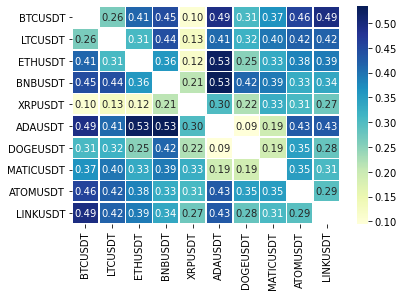

In [502]:
maph = hurstplot(Combine)

heat_map(maph)

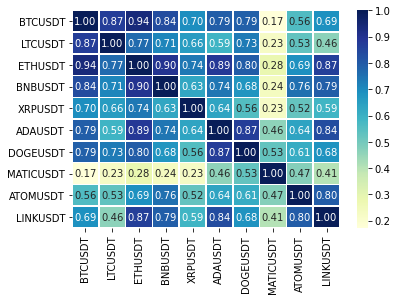

In [503]:
corre = Combine.corr()
heat_map(corre)

In [504]:
#Combine.corr().to_latex()

In [505]:
#hurstplot(Combine).to_latex()

C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable i

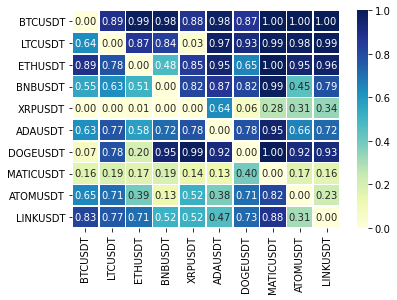

In [506]:
cointe = cointplot(Combine)
heat_map(cointe)

In [507]:
#cointplot(Combine).to_latex()

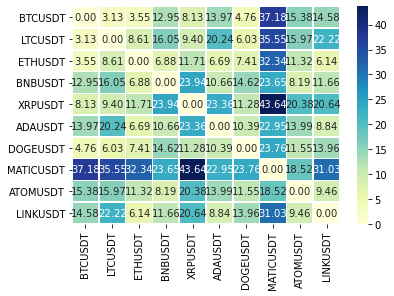

In [508]:
dist = Pair_Selection_Smallest_Distance(Combine)
heat_map(dist)

We will test the distance-beased pair trading with BTC/USDT and ETH/USDT. The figure below is the normalized price of the pair of the coins. The strong correlation and divergence are shown in the plot.

## Backtesing System

In [703]:
import pandas as pd
import epymetheus as ep

#epymetheus.trade(asset, entry=None, exit=None, take=None, stop=None, lot=1.0, **kwargs)[source]
#epymetheus.create_strategy(fn, **params)


def dumb_strategy(universe: pd.DataFrame, profit_take, stop_loss):
    # I get $100 allowance on the first business day of each month
    allowance = 1

    for date in pd.date_range(universe.index[0], universe.index[-1], freq="BMS"):
        cheapest_stock = universe.loc[date].idxmin()

        # Find the maximum number of shares that I can buy with my allowance
        n_shares = allowance // universe.at[date, cheapest_stock]

        trade = n_shares * ep.trade(cheapest_stock, date, take=profit_take, stop=stop_loss)
        yield trade

In [704]:
def Train_Distance(Train: pd.DataFrame):
    diff_norm = Train.iloc[:,0] - Train.iloc[:,1]
    return diff_norm.mean(), diff_norm.std()

def Distance_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, thed, mu, sd, allow):
    #universe_norm = (universe - universe.min())/(universe.max() - universe.min())
    stock = universe.columns
    diff_norm = universe.iloc[:,0] - universe.iloc[:,1]
    lbound = mu - thed*sd
    ubound = mu + thed*sd
    for date in universe.index:
        if diff_norm[date] > ubound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [-lot_win, lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade
        if diff_norm[date] < lbound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade            


In [820]:
def Train_Cointegration(Train: pd.DataFrame):
    reg = LinearRegression().fit(np.array(Train.iloc[:,0]).reshape(-1, 1), np.array(Train.iloc[:,1]).reshape(-1, 1))
    m = reg.coef_
    c = reg.intercept_
    res = Train.iloc[:,1] - (m[0]*Train.iloc[:,0] + c)
    return res.mean(), res.std(), m[0]


def Cointegration_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, thed, mu, sd, allow):
    #universe_norm = (universe - universe.min())/(universe.max() - universe.min())
    stock = universe.columns
    diff_norm = universe.iloc[:,0] - universe.iloc[:,1]
    lbound = mu - thed*sd
    ubound = mu + thed*sd
    for date in universe.index:
        if diff_norm[date] > ubound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [-lot_win, lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade
        if diff_norm[date] < lbound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade            

In [707]:
def Train_Correlation(Train: pd.DataFrame):
    return Train.iloc[:,0].corr(Train.iloc[:,1])

def Correlation_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, lag, thed, allow):
    stock = universe.columns
    agrcor = [universe.iloc[(i-lag):i,0].corr(universe.iloc[(i-lag):i,1]) for i in range(lag,universe.shape[0])]
    CorFrame = pd.DataFrame({'Date':universe.tail(universe.shape[0]-lag).index, 'Cor':agrcor}).set_index('Date')
    for date in CorFrame.index:
        if CorFrame.at[date,'Cor'] < -thed:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade

In [747]:
interval = '1d'
startTime =  datetime.datetime(2020, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 1, 1, 0, 0).timestamp()*1000
ticker = ['XRPUSDT','LTCUSDT']
Combine = priceFrame(ticker,interval,startTime,endTime)

In [806]:
#df_history
#dec_vec = [int((df_history['close'][i] - df_history['entry'][i+1]).days) for i in range(df_history.shape[0]-1)]
#dec_vec
def modify_bt(x):
    st = x.head(2)
    st_c = st['close'][0]
    for i in range(2,x.shape[0]-1,2):
        if x['entry'][i] > st_c:
            st = pd.concat([st, x.loc[[i,i+1],:]])
            st_c = x['close'][i]
    dif_day = (st['close'] - st['entry']).dt.days
    inter = [0.0003*int(i < 0) for i in st['lot']]
    st['interest'] = inter * dif_day * 100   
    st['fee']  = 0.001*100
    st['trade_id'] = np.repeat(list(range(0,int(st.shape[0]/2))),2,axis=0)
    st['totalasset'] =  st['pnl'] - st['interest'] - st['fee'] 
    st['cumtotalasset'] =  np.cumsum(st['totalasset'])
    return(st)

### Experiment for the Distance Pair Trading

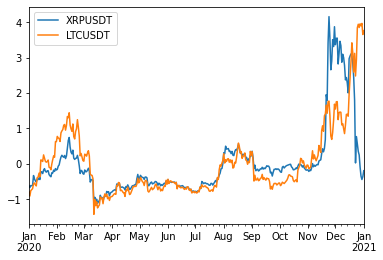

In [748]:
((Combine - Combine.mean())/Combine.std()).plot()

In [822]:
mu, sd = Train_Distance(Combine)
print(mu,sd)

-56.12420716621251 18.49507867598505


In [800]:
my_strategy = ep.create_strategy(Distance_Pair_Trading, profit_take=30, stop_loss=-30, thed = 5, mu = mu, sd = sd, allow = 100)

In [801]:
interval = '1d'
startTime =  datetime.datetime(2021, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2022, 1, 1, 0, 0).timestamp()*1000
ticker = ['XRPUSDT','LTCUSDT']
universe = priceFrame(ticker,interval,startTime,endTime)

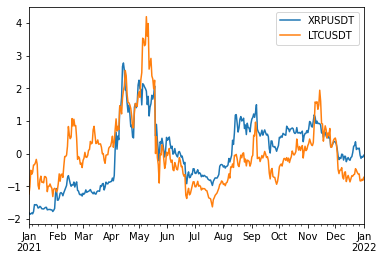

In [802]:
((universe - universe.mean())/universe.std()).plot()

In [803]:
my_strategy.run(universe)

277 trades returned: trade(['XRPUSDT' 'LTCUSDT'], lot=[104.85477614  -0.64350064], entry=2021-12-22 00:00:00, take=30, stop=-30) ... 283 trades returned: trade(['XRPUSDT' 'LTCUSDT'], lot=[117.55025273  -0.66312997], entry=2022-01-01 00:00:00, take=30, stop=-30) ... Done. (Runtume: 0.4080 sec)
283 trades executed: trade(['XRPUSDT' 'LTCUSDT'], lot=[117.55025273  -0.66312997], entry=2022-01-01 00:00:00, take=30, stop=-30) ... Done. (Runtime: 1.2530 sec)
Done. Final wealth: 3969.59 (Runtime: 1.6620 sec)


strategy(Distance_Pair_Trading, profit_take=30, stop_loss=-30, thed=5, mu=-56.12420716621251, sd=18.49507867598505, allow=100)

In [804]:
df_history = my_strategy.history()
pd.set_option('display.max_rows', df_history.shape[0]+1)
df_history

,trade_id,asset,lot,entry,close,exit,take,stop,pnl
0,0,XRPUSDT,443.655723,2021-01-03,2021-01-07,None,30,-30,43.695652
1,0,LTCUSDT,-0.620194,2021-01-03,2021-01-07,None,30,-30,-5.029769
2,1,XRPUSDT,424.358158,2021-01-04,2021-01-29,None,30,-30,20.050923
3,1,LTCUSDT,-0.643749,2021-01-04,2021-01-29,None,30,-30,13.319171
4,2,XRPUSDT,443.007132,2021-01-05,2021-01-07,None,30,-30,43.485580
5,2,LTCUSDT,-0.631194,2021-01-05,2021-01-07,None,30,-30,-6.892634
6,3,XRPUSDT,402.349722,2021-01-06,2021-01-29,None,30,-30,13.824736
7,3,LTCUSDT,-0.591996,2021-01-06,2021-01-29,None,30,-30,20.287710
8,4,XRPUSDT,308.746797,2021-01-07,2021-01-30,None,30,-30,36.997129
9,4,LTCUSDT,-0.590493,2021-01-07,2021-01-30,None,30,-30,21.251845


In [805]:
#df_history.drop_duplicates(subset=['entry', 'close','asset'], keep='first')

In [807]:
real_his = modify_bt(df_history)
real_his
#times = pd.date_range('2021-01-01', '2022-01-01')

,trade_id,asset,lot,entry,close,exit,take,stop,pnl,interest,fee,totalasset,cumtotalasset
0,0,XRPUSDT,443.655723,2021-01-03,2021-01-07,None,30,-30,43.695652,0.00,0.1,43.595652,43.595652
1,0,LTCUSDT,-0.620194,2021-01-03,2021-01-07,None,30,-30,-5.029769,0.12,0.1,-5.249769,38.345883
10,1,XRPUSDT,312.187812,2021-01-08,2021-01-30,None,30,-30,38.523976,0.00,0.1,38.423976,76.769859
11,1,LTCUSDT,-0.580754,2021-01-08,2021-01-30,None,30,-30,22.550671,0.66,0.1,21.790671,98.560530
24,2,XRPUSDT,251.755998,2021-02-03,2021-04-04,None,30,-30,59.865059,0.00,0.1,59.765059,158.325588
25,2,LTCUSDT,-0.641313,2021-02-03,2021-04-04,None,30,-30,-29.679985,1.80,0.1,-31.579985,126.745604
144,3,XRPUSDT,109.189378,2021-04-05,2021-08-11,None,30,-30,10.335867,0.00,0.1,10.235867,136.981470
145,3,LTCUSDT,-0.451508,2021-04-05,2021-08-11,None,30,-30,22.972729,3.84,0.1,19.032729,156.014199
306,4,XRPUSDT,103.519669,2021-08-12,2022-01-01,None,30,-30,-11.935818,0.00,0.1,-12.035818,143.978381
307,4,LTCUSDT,-0.604668,2021-08-12,2022-01-01,None,30,-30,8.816060,4.26,0.1,4.456060,148.434441


In [811]:
real_his.drop(['exit','take','stop'],axis = 1).to_latex(index= False)

'\\begin{tabular}{rlrllrrrrr}\n\\toprule\n trade\\_id &    asset &         lot &      entry &      close &        pnl &  interest &  fee &  totalasset &  cumtotalasset \\\\\n\\midrule\n        0 &  XRPUSDT &  443.655723 & 2021-01-03 & 2021-01-07 &  43.695652 &      0.00 &  0.1 &   43.595652 &      43.595652 \\\\\n        0 &  LTCUSDT &   -0.620194 & 2021-01-03 & 2021-01-07 &  -5.029769 &      0.12 &  0.1 &   -5.249769 &      38.345883 \\\\\n        1 &  XRPUSDT &  312.187812 & 2021-01-08 & 2021-01-30 &  38.523976 &      0.00 &  0.1 &   38.423976 &      76.769859 \\\\\n        1 &  LTCUSDT &   -0.580754 & 2021-01-08 & 2021-01-30 &  22.550671 &      0.66 &  0.1 &   21.790671 &      98.560530 \\\\\n        2 &  XRPUSDT &  251.755998 & 2021-02-03 & 2021-04-04 &  59.865059 &      0.00 &  0.1 &   59.765059 &     158.325588 \\\\\n        2 &  LTCUSDT &   -0.641313 & 2021-02-03 & 2021-04-04 & -29.679985 &      1.80 &  0.1 &  -31.579985 &     126.745604 \\\\\n        3 &  XRPUSDT &  109.189378 

(array([737791., 737850., 737911., 737972., 738034., 738095., 738156.]),
 <a list of 7 Text major ticklabel objects>)

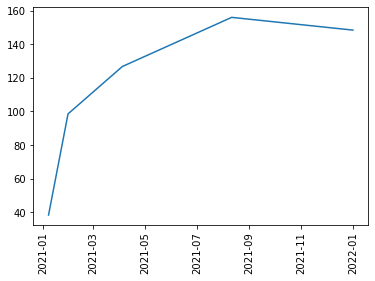

In [789]:
plot_w = real_his[['close','cumtotalasset']].drop_duplicates(subset=['close'], keep='last')
plt.plot(plot_w['close'], plot_w['cumtotalasset'])
plt.xticks(rotation='vertical')

### Experiment for Cointegartion Pair Trading 

In [823]:
mu, sd, beta = Train_Cointegration(Combine)
print(mu,sd,beta)

-1.7037536988253083e-15 13.942326695982018 [116.95747998]


In [813]:
my_strategy = ep.create_strategy(Cointegration_Pair_Trading, profit_take=30, stop_loss=-30, 
                                thed = 5, mu = mu, sd = sd, allow = 100)

In [814]:
my_strategy.run(universe)
df_history = my_strategy.history()
pd.set_option('display.max_rows', df_history.shape[0]+1)
df_history

366 trades returned: trade(['XRPUSDT' 'LTCUSDT'], lot=[117.55025273  -0.66312997], entry=2022-01-01 00:00:00, take=30, stop=-30) ... Done. (Runtume: 0.4690 sec)
74 trades executed: trade(['XRPUSDT' 'LTCUSDT'], lot=[229.49465277  -0.49852934], entry=2021-03-15 00:00:00, take=30, stop=-30) ... 366 trades executed: trade(['XRPUSDT' 'LTCUSDT'], lot=[117.55025273  -0.66312997], entry=2022-01-01 00:00:00, take=30, stop=-30) ... Done. (Runtime: 1.4110 sec)
Done. Final wealth: 6836.97 (Runtime: 1.8810 sec)


,trade_id,asset,lot,entry,close,exit,take,stop,pnl
0,0,XRPUSDT,421.123558,2021-01-01,2021-01-30,None,30,-30,86.860945
1,0,LTCUSDT,-0.792142,2021-01-01,2021-01-30,None,30,-30,-5.640051
2,1,XRPUSDT,453.226976,2021-01-02,2021-01-30,None,30,-30,101.105874
3,1,LTCUSDT,-0.730140,2021-01-02,2021-01-30,None,30,-30,2.628505
4,2,XRPUSDT,443.655723,2021-01-03,2021-01-07,None,30,-30,43.695652
5,2,LTCUSDT,-0.620194,2021-01-03,2021-01-07,None,30,-30,-5.029769
6,3,XRPUSDT,424.358158,2021-01-04,2021-01-29,None,30,-30,20.050923
7,3,LTCUSDT,-0.643749,2021-01-04,2021-01-29,None,30,-30,13.319171
8,4,XRPUSDT,443.007132,2021-01-05,2021-01-07,None,30,-30,43.485580
9,4,LTCUSDT,-0.631194,2021-01-05,2021-01-07,None,30,-30,-6.892634


In [815]:
real_his = modify_bt(df_history)
real_his

,trade_id,asset,lot,entry,close,exit,take,stop,pnl,interest,fee,totalasset,cumtotalasset
0,0,XRPUSDT,421.123558,2021-01-01,2021-01-30,None,30,-30,86.860945,0.00,0.1,86.760945,86.760945
1,0,LTCUSDT,-0.792142,2021-01-01,2021-01-30,None,30,-30,-5.640051,0.87,0.1,-6.610051,80.150894
60,1,XRPUSDT,201.991638,2021-01-31,2021-07-28,None,30,-30,47.999273,0.00,0.1,47.899273,128.050167
61,1,LTCUSDT,-0.773036,2021-01-31,2021-07-28,None,30,-30,-8.549784,5.34,0.1,-13.989784,114.060384
418,2,XRPUSDT,133.547009,2021-07-29,2022-01-01,None,30,-30,13.608440,0.00,0.1,13.508440,127.568824
419,2,LTCUSDT,-0.707014,2021-07-29,2022-01-01,None,30,-30,-6.617647,4.68,0.1,-11.397647,116.171177


In [818]:
real_his.drop(['exit','take','stop'],axis = 1).to_latex(index= False)

'\\begin{tabular}{rlrllrrrrr}\n\\toprule\n trade\\_id &    asset &         lot &      entry &      close &        pnl &  interest &  fee &  totalasset &  cumtotalasset \\\\\n\\midrule\n        0 &  XRPUSDT &  421.123558 & 2021-01-01 & 2021-01-30 &  86.860945 &      0.00 &  0.1 &   86.760945 &      86.760945 \\\\\n        0 &  LTCUSDT &   -0.792142 & 2021-01-01 & 2021-01-30 &  -5.640051 &      0.87 &  0.1 &   -6.610051 &      80.150894 \\\\\n        1 &  XRPUSDT &  201.991638 & 2021-01-31 & 2021-07-28 &  47.999273 &      0.00 &  0.1 &   47.899273 &     128.050167 \\\\\n        1 &  LTCUSDT &   -0.773036 & 2021-01-31 & 2021-07-28 &  -8.549784 &      5.34 &  0.1 &  -13.989784 &     114.060384 \\\\\n        2 &  XRPUSDT &  133.547009 & 2021-07-29 & 2022-01-01 &  13.608440 &      0.00 &  0.1 &   13.508440 &     127.568824 \\\\\n        2 &  LTCUSDT &   -0.707014 & 2021-07-29 & 2022-01-01 &  -6.617647 &      4.68 &  0.1 &  -11.397647 &     116.171177 \\\\\n\\bottomrule\n\\end{tabular}\n'

(array([737850., 737911., 737972., 738034., 738095., 738156.]),
 <a list of 6 Text major ticklabel objects>)

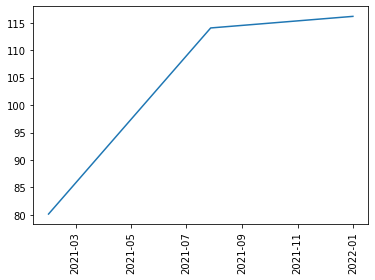

In [817]:
plot_w = real_his[['close','cumtotalasset']].drop_duplicates(subset=['close'], keep='last')
plt.plot(plot_w['close'], plot_w['cumtotalasset'])
plt.xticks(rotation='vertical')

## Buy and Hold

In [796]:
(float(Combine['XRPUSDT'].tail(1))/float(Combine['XRPUSDT'].head(1))) -1 

1.23004403004403

In [798]:
(float(Combine['LTCUSDT'].tail(1))/float(Combine['LTCUSDT'].head(1))) - 1

2.0331571359923113

In [831]:
216.171177/100 -1 

1.1617117700000001